# Fraud Detection Pipeline
This notebook contains the full pipeline for EDA, preprocessing, model training, and evaluation of the fraud detection dataset.

In [6]:

# --- IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

# Optional (for anomaly detection)
from sklearn.ensemble import IsolationForest


## 🧠 Are CASH_OUT and TRANSFER predictors?
✅ YES—they can absolutely become predictors in your model.

Right now:

They’re categories in the Type column (CASH_IN, CASH_OUT, PAYMENT, etc.)

So technically Type is a single categorical feature.

But:

Because fraud concentrates in specific types like CASH_OUT and TRANSFER, you can engineer new features from them that will help your model.

🔥 How to turn Type into useful predictors?
✅ 1. One-hot encode transaction types
Turn Type into separate binary columns:

CASH_OUT	TRANSFER	PAYMENT	…
1	0	0	…
0	1	0	…
0	0	1	…

This lets the model learn which types are high risk.

python
Copy
Edit
df = pd.get_dummies(df, columns=['Type'], drop_first=True)
✅ 2. Create a “High Risk Type” flag
Since CASH_OUT and TRANSFER are more fraud-prone, engineer a single binary feature:

python
Copy
Edit
df['HighRiskType'] = df['Type'].isin(['CASH_OUT', 'TRANSFER']).astype(int)
HighRiskType
1
0
1

Now the model knows whether a transaction is in a high fraud risk category.

✅ 3. Interaction Features (Optional)
Combine Type with numerical features:

Fraud might happen only for large amounts in CASH_OUT

python
Copy
Edit
df['CashOut_LargeAmount'] = (
    (df['Type'] == 'CASH_OUT') & (df['Amount'] > 10000)
).astype(int)
🔑 Why is this important?
✅ Models like Logistic Regression won’t handle Type directly unless you encode it.
✅ Tree-based models (Random Forest, XGBoost) can work with categorical encodings—but engineered flags make them even stronger.

In [7]:

# --- LOAD DATA ---
# Replace 'bank_transactions.csv' with your dataset filename
bank_df = pd.read_csv('../data/bank_transactions.csv')
bank_df.head()


,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,983.09,C1454812978,36730.24,35747.15,M1491308340,0.00,0.00,0,0
1,PAYMENT,55215.25,C1031766358,99414.00,44198.75,M2102868029,0.00,0.00,0,0
2,CASH_IN,220986.01,C1451868666,7773074.97,7994060.98,C1339195526,924031.48,703045.48,0,0
3,TRANSFER,2357394.75,C458368123,0.00,0.00,C620979654,4202580.45,6559975.19,0,0
4,CASH_OUT,67990.14,C1098978063,0.00,0.00,C142246322,625317.04,693307.19,0,0


             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  1.000000e+06   1.000000e+06    1.000000e+06    1.000000e+06   
mean   1.796208e+05   8.351184e+05    8.565104e+05    1.102856e+06   
std    6.076181e+05   2.892918e+06    2.928896e+06    3.464915e+06   
min    0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.336939e+04   0.000000e+00    0.000000e+00    0.000000e+00   
50%    7.443500e+04   1.411000e+04    0.000000e+00    1.331849e+05   
75%    2.083404e+05   1.073804e+05    1.446566e+05    9.430209e+05   
max    9.244552e+07   3.958504e+07    3.893942e+07    3.555534e+08   

       newbalanceDest         isFraud  isFlaggedFraud  
count    1.000000e+06  1000000.000000  1000000.000000  
mean     1.227859e+06        0.001297        0.000001  
std      3.752688e+06        0.035991        0.001000  
min      0.000000e+00        0.000000        0.000000  
25%      0.000000e+00        0.000000        0.000000  
50%      2.148652e+05        0.00

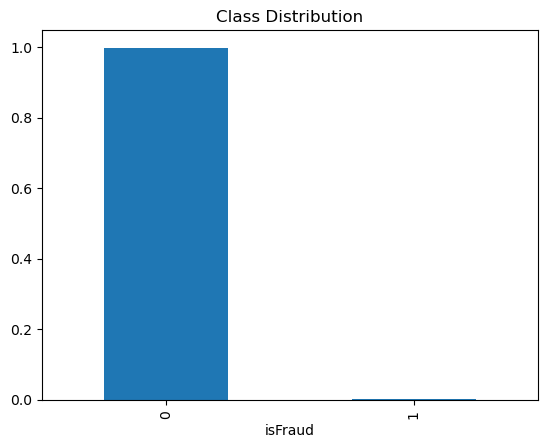

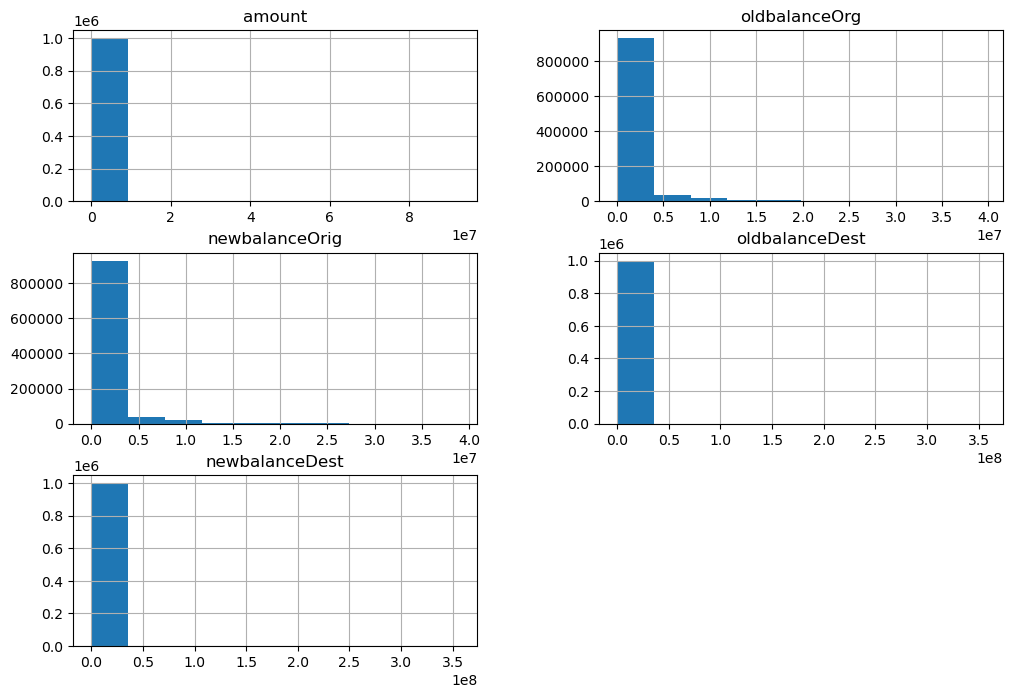

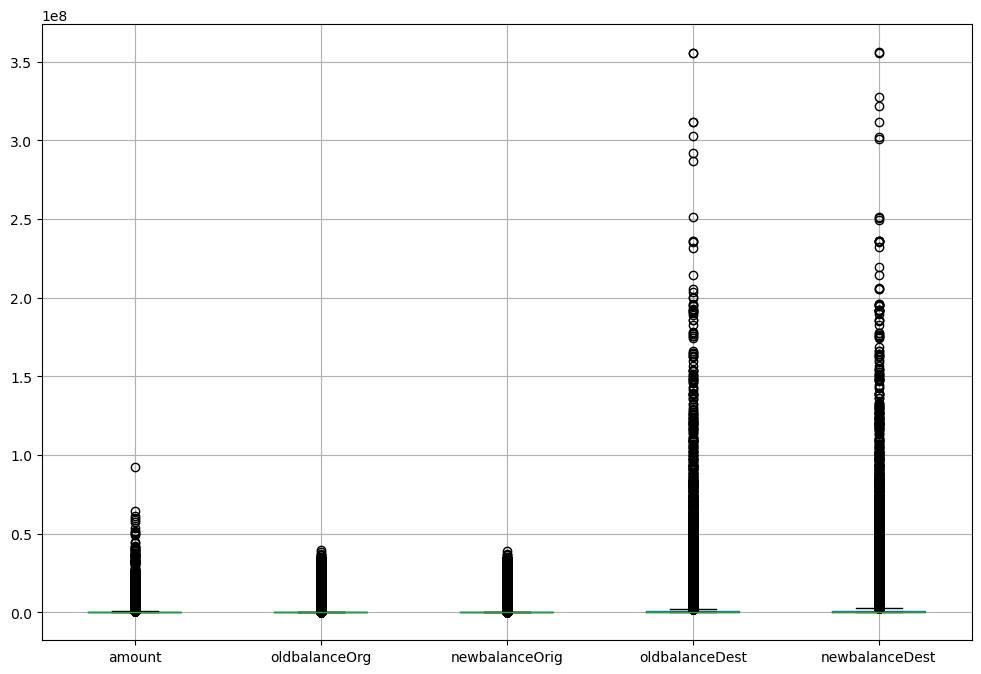

In [12]:

# --- EDA ---
# 1. Univariate Analysis
print(bank_df.describe())
bank_df['isFraud'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution')
plt.show()

# Histograms of numeric features
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
bank_df[numeric_cols].hist(figsize=(12, 8))
plt.show()

# Box plots for numeric features
# Histograms of numeric features
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
bank_df[numeric_cols].boxplot(figsize=(12, 8))
plt.show()



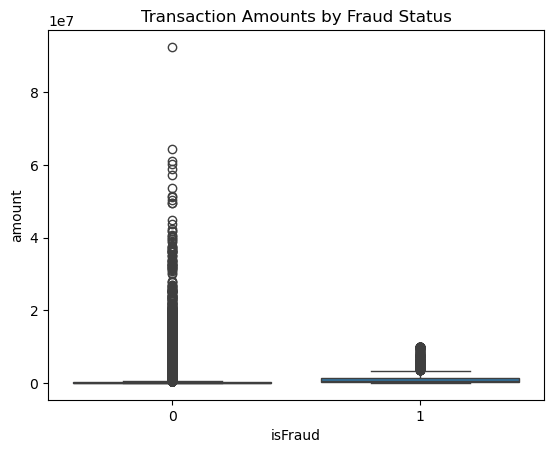

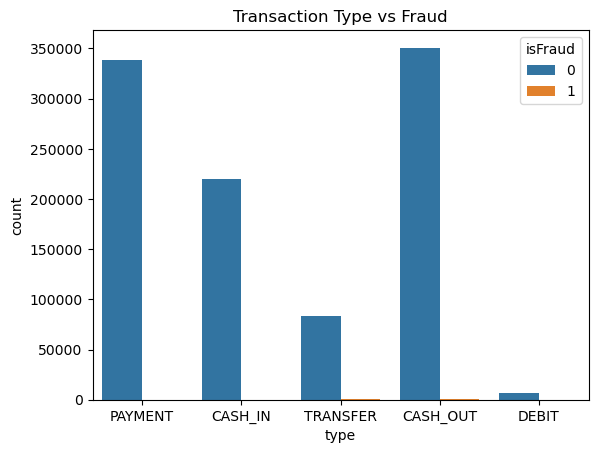

isFraud,0,1
isFlaggedFraud,,
0,0.998704,0.001296
1,0.000000,1.000000


In [13]:

# 2. Bivariate Analysis
sns.boxplot(x='isFraud', y='amount', data=bank_df)
plt.title('Transaction Amounts by Fraud Status')
plt.show()

sns.countplot(x='type', hue='isFraud', data=bank_df)
plt.title('Transaction Type vs Fraud')
plt.show()

# Check current fraud flag performance
pd.crosstab(bank_df['isFlaggedFraud'], bank_df['isFraud'], normalize='index')

In [ ]:

# --- DATA TRANSFORMATION ---
# Drop non-predictive columns
df = bank_df.drop(['nameOrig', 'nameDest'], axis=1)

# Encode categorical feature 'Type'
df['Type'] = LabelEncoder().fit_transform(df['Type'])

# Separate features and target
X = df.drop(['IsFraud'], axis=1)
y = df['IsFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scale numeric features
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


KeyError: "['NameOrig', 'NameDest'] not found in axis"

In [ ]:

# --- MODEL TRAINING ---

# Logistic Regression
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train_res_scaled, y_train_res)
y_pred_lr = logreg.predict(X_test_scaled)
print("\nLogistic Regression")
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest")
print(classification_report(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(scale_pos_weight=(len(y_train_res) - sum(y_train_res)) / sum(y_train_res),
                     use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost")
print(classification_report(y_test, y_pred_xgb))


In [ ]:

# Optional: Isolation Forest (Anomaly Detection)
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Convert anomaly flag to fraud label
print("\nIsolation Forest")
print(classification_report(y_test, y_pred_iso))


In [ ]:

# --- EVALUATION ---
def plot_roc_pr(y_true, y_scores, label):
    from sklearn.metrics import roc_curve, precision_recall_curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{label} ROC')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{label} PR')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Plot ROC & PR for XGBoost (example)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
plot_roc_pr(y_test, y_prob_xgb, 'XGBoost')


In [ ]:

# --- FEATURE IMPORTANCE ---
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_rf.sort_values().plot(kind='barh', title='Random Forest Feature Importances')
plt.show()

importances_xgb = pd.Series(xgb.feature_importances_, index=X.columns)
importances_xgb.sort_values().plot(kind='barh', title='XGBoost Feature Importances')
plt.show()
